## Boundary Conditions in Finite Difference Methods

In this notebook, we extend the Crank-Nicolson PDE implementation by incorporating **boundary conditions**, a critical component of PDE stability and accuracy.

We will explore:
- **Dirichlet Boundary Conditions**: Fixed value at domain edges.
- **Neumann Boundary Conditions**: Fixed derivative (slope) at domain edges.

We'll examine how these affect the pricing of vanilla European options, comparing numerical solutions with analytical Black-Scholes prices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [4]:
# Black-Scholes Analytical Formula

def bs_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [5]:
#  Crank-Nicolson PDE with Boundary Condition Selection

def crank_nicolson_boundary(S_max, K, T, r, sigma, M, N, option_type='call', bc_type='dirichlet'):
    dt = T / N
    dS = S_max / M
    S = np.linspace(0, S_max, M+1)

    # Payoff at maturity
    if option_type == 'call':
        V = np.maximum(S - K, 0)
    else:
        V = np.maximum(K - S, 0)

    alpha = 0.25 * dt * (sigma**2 * (np.arange(M+1))**2 - r * np.arange(M+1))
    beta = -dt * 0.5 * (sigma**2 * (np.arange(M+1))**2 + r)
    gamma = 0.25 * dt * (sigma**2 * (np.arange(M+1))**2 + r * np.arange(M+1))

    A = np.zeros((M-1, M-1))
    B = np.zeros((M-1, M-1))

    for i in range(1, M):
        if i != 1:
            A[i-1, i-2] = -alpha[i]
            B[i-1, i-2] = alpha[i]
        A[i-1, i-1] = 1 - beta[i]
        B[i-1, i-1] = 1 + beta[i]
        if i != M-1:
            A[i-1, i] = -gamma[i]
            B[i-1, i] = gamma[i]

    for j in range(N):
        rhs = B @ V[1:M]

        # Boundary conditions
        if bc_type == 'dirichlet':
            rhs[0] += alpha[1] * 0  # V(0) = 0
            rhs[-1] += gamma[M-1] * (S_max - K if option_type == 'call' else 0)
        elif bc_type == 'neumann':
            rhs[0] += alpha[1] * (V[2] - V[0]) / (2 * dS)
            rhs[-1] += gamma[M-1] * (V[M] - V[M-2]) / (2 * dS)

        V[1:M] = np.linalg.solve(A, rhs)

        # Dirichlet BC at edges
        if bc_type == 'dirichlet':
            V[0] = 0
            V[M] = S_max - K * np.exp(-r * (T - j * dt)) if option_type == 'call' else 0
        elif bc_type == 'neumann':
            V[0] = V[1]
            V[M] = V[M-1]

    return S, V

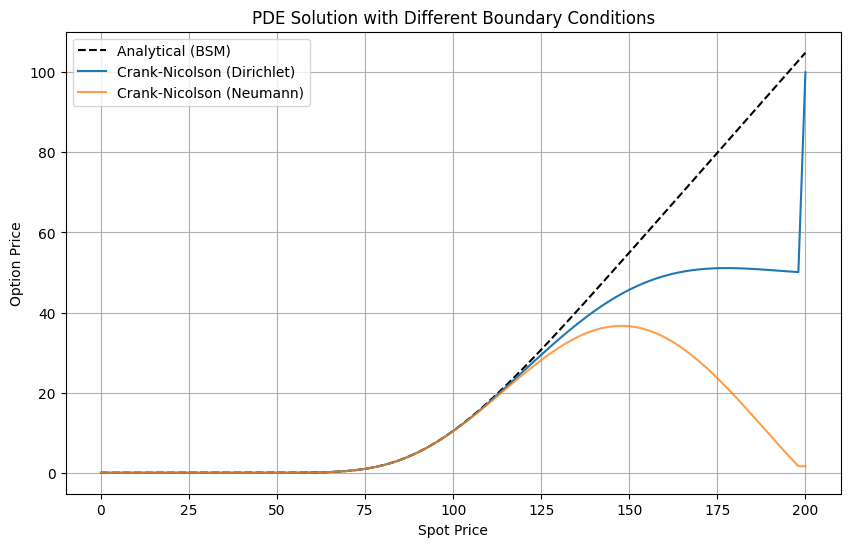

In [6]:
# Parameters
S_max = 200
K = 100
T = 1
r = 0.05
sigma = 0.2
M = 100
N = 1000

S1, V_dirichlet = crank_nicolson_boundary(S_max, K, T, r, sigma, M, N, option_type='call', bc_type='dirichlet')
S2, V_neumann = crank_nicolson_boundary(S_max, K, T, r, sigma, M, N, option_type='call', bc_type='neumann')

S_analytical = np.linspace(0.01, S_max, 1000)
V_analytical = bs_price(S_analytical, K, T, r, sigma, option_type='call')

plt.figure(figsize=(10, 6))
plt.plot(S_analytical, V_analytical, 'k--', label='Analytical (BSM)')
plt.plot(S1, V_dirichlet, label='Crank-Nicolson (Dirichlet)')
plt.plot(S2, V_neumann, label='Crank-Nicolson (Neumann)', alpha=0.75)
plt.title('PDE Solution with Different Boundary Conditions')
plt.xlabel('Spot Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

## Observations

- **Dirichlet Boundary Condition** enforces exact values at boundaries, often making it easier to interpret but may cause numerical artifacts if boundary values are not ideal.
- **Neumann Boundary Condition** maintains gradient at the edges, often leading to smoother transitions but is harder to calibrate.
- Both conditions show convergence to the analytical BSM solution for well-chosen domain and discretization.

We will reuse this flexible engine when solving PDEs for exotic options like Barrier and American options.